In [19]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [20]:
# Load the dataset
df = pd.read_csv("C:/Users/Gurinder/Desktop/Ranking System/Data File/TRADES_CopyTr_90D_ROI.csv")  # Update path if needed

In [21]:
# Ensure 'Trade_History' column is read as a string and parsed correctly
def safe_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except (ValueError, SyntaxError):
        return None

df['Trade_History'] = df['Trade_History'].apply(safe_eval)

In [22]:
# Drop rows with invalid Trade_History
df = df.dropna(subset=['Trade_History']).reset_index(drop=True)

In [23]:
# Helper function to flatten the 'Trade_History'
def extract_trade_data(trade_history, port_id):
    trades = []
    for trade in trade_history:
        trade_data = trade.copy()
        trade_data['Port_IDs'] = port_id
        trades.append(trade_data)
    return trades

In [24]:
# Flatten trade data
all_trades = []
for _, row in df.iterrows():
    if isinstance(row['Trade_History'], list):
        all_trades.extend(extract_trade_data(row['Trade_History'], row['Port_IDs']))

df_trades = pd.DataFrame(all_trades)

In [25]:
# Step 1: Calculate PnL
df_trades['PnL'] = df_trades['realizedProfit']

In [26]:
# Step 2: Calculate ROI
df_trades['Investment'] = df_trades['quantity'] * df_trades['price']
df_trades['ROI'] = (df_trades['PnL'] / df_trades['Investment']).replace([np.inf, -np.inf], np.nan) * 100

In [27]:
# Step 3: Calculate Sharpe Ratio
sharpe_ratios = {}
for port_id, group in df_trades.groupby('Port_IDs'):
    mean_returns = group['PnL'].mean()
    std_dev_returns = group['PnL'].std()
    sharpe_ratios[port_id] = (mean_returns / std_dev_returns) if std_dev_returns != 0 else np.nan

In [28]:
# Step 4: Calculate Maximum Drawdown (MDD)
df_trades['cumulative_profit'] = df_trades.groupby('Port_IDs')['PnL'].cumsum()
df_trades['peak'] = df_trades.groupby('Port_IDs')['cumulative_profit'].cummax()
df_trades['drawdown'] = ((df_trades['cumulative_profit'] - df_trades['peak']) / df_trades['peak']).replace([np.inf, -np.inf], np.nan)
max_drawdowns = df_trades.groupby('Port_IDs')['drawdown'].min()

In [29]:
# Step 5: Calculate Win Rate and Win Positions
df_trades['Win'] = df_trades['PnL'] > 0
win_positions = df_trades.groupby('Port_IDs')['Win'].sum()
total_positions = df_trades.groupby('Port_IDs').size()
win_rates = (win_positions / total_positions).round(2)

In [30]:
# Step 6: Combine metrics for ranking
metrics = pd.DataFrame({
    'Port_IDs': win_positions.index,
    'Total_PnL': df_trades.groupby('Port_IDs')['PnL'].sum().round(3),
    'Total_ROI': df_trades.groupby('Port_IDs')['ROI'].mean().round(2),
    'Sharpe_Ratio': pd.Series(sharpe_ratios),
    'Max_Drawdown': max_drawdowns.round(2),
    'Win_Rate': win_rates,
    'Total_Positions': total_positions,
    'Win_Positions': win_positions
}).reset_index(drop=True)

In [31]:
# Weighted Scoring System
weights = {
    'Total_ROI': 0.3,
    'Total_PnL': 0.25,
    'Sharpe_Ratio': 0.2,
    'Win_Rate': 0.15,
    'Max_Drawdown': -0.1 
}

In [32]:
for metric, weight in weights.items():
    metrics[metric + '_Score'] = metrics[metric] * weight

metrics['Rank_Score'] = metrics[[metric + '_Score' for metric in weights]].sum(axis=1)

In [33]:
# Rank accounts
metrics = metrics.sort_values(by='Rank_Score', ascending=False)

In [34]:
# Save metrics to CSV
output_file = 'C:/Users/Gurinder/Desktop/Ranking System/Data File/final_account_ranking.csv'
metrics.to_csv(output_file, index=False)

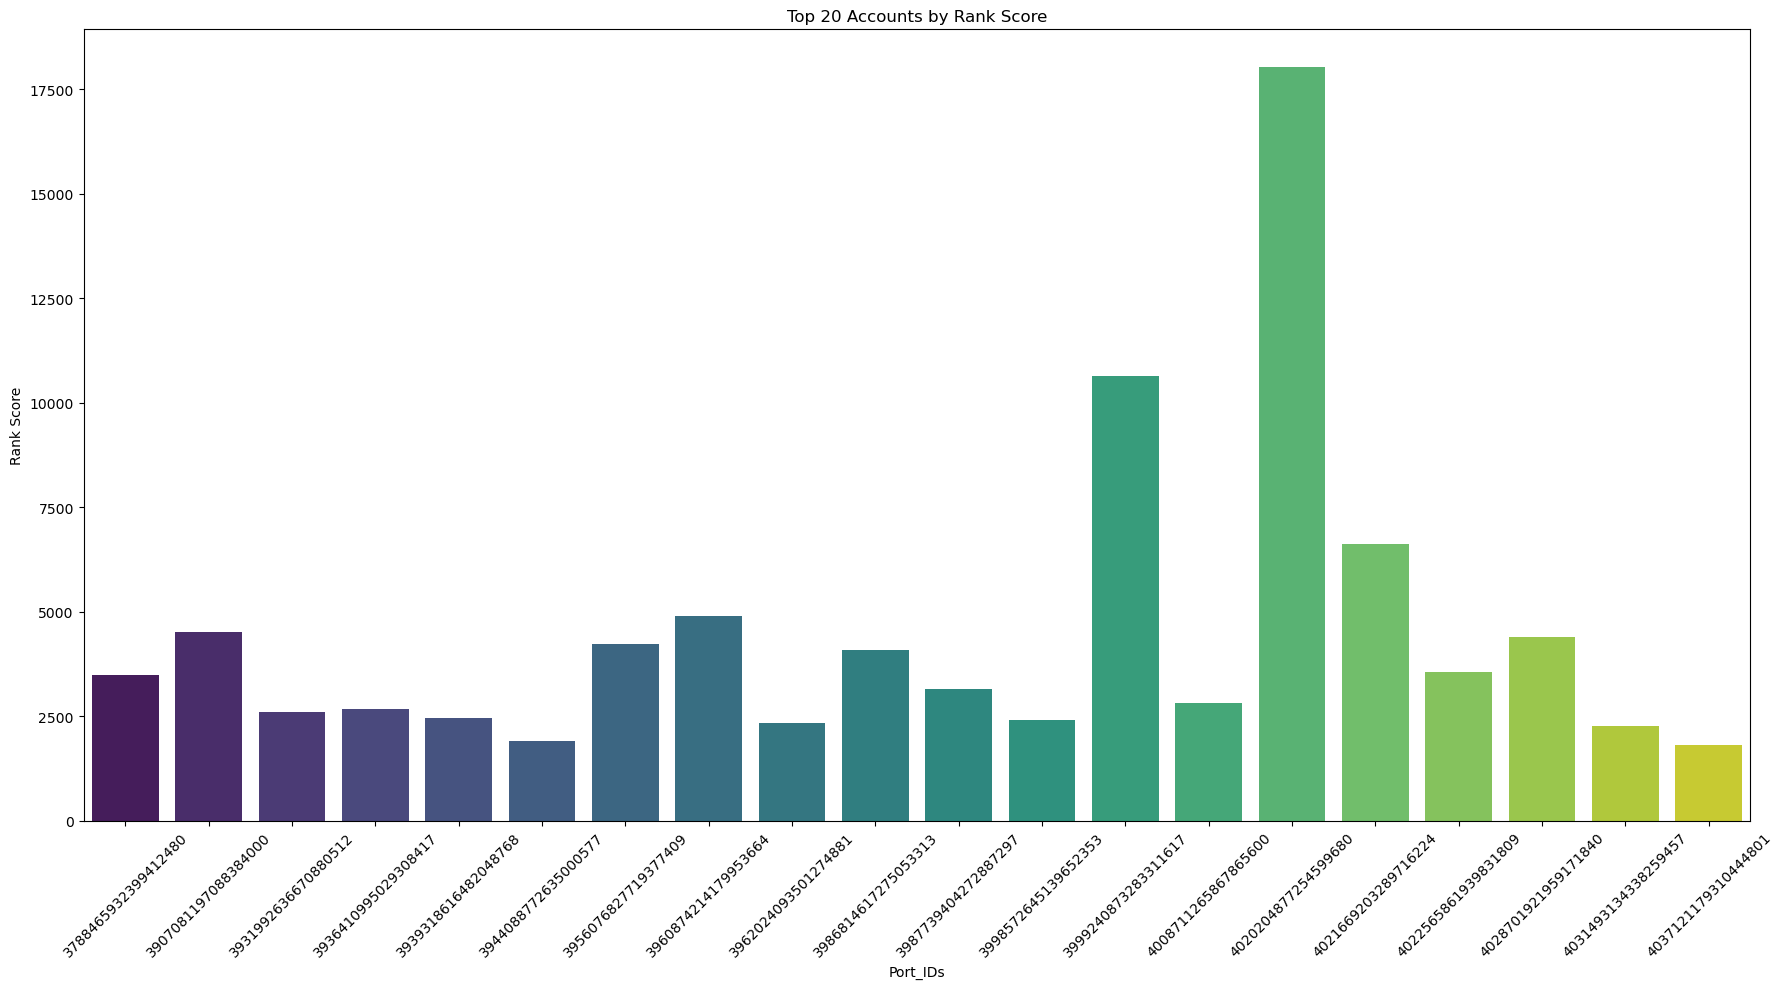

In [35]:
# Visualization
plt.figure(figsize=(18, 10))
sns.barplot(x=metrics['Port_IDs'].head(20), y=metrics['Rank_Score'].head(20), palette="viridis")
plt.title('Top 20 Accounts by Rank Score')
plt.xlabel('Port_IDs')
plt.ylabel('Rank Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# Top 20 Accounts
top_20_accounts = metrics.head(20)
print(top_20_accounts)

                Port_IDs  Total_PnL  Total_ROI  Sharpe_Ratio  Max_Drawdown  \
96   4020204877254599680  71998.856      95.04      0.060748         -8.03   
75   3999240873283311617  42574.474      11.04      0.227505         -0.05   
98   4021669203289716224  26427.332      -2.74      0.068251         -0.16   
50   3960874214179953664  19567.471       2.44      0.162948        -34.54   
17   3907081197088384000  18015.997      30.85      0.222729         -0.24   
107  4028701921959171840  17601.401       0.00      0.275724         -0.05   
48   3956076827719377409  16790.012      66.49      0.099528         -0.25   
62   3986814617275053313  16337.462      14.28      0.329787         -0.00   
99   4022565861939831809  14197.577       0.02      0.299602         -0.11   
5    3788465932399412480  13960.966       0.36      0.152912         -0.22   
63   3987739404272887297  12464.606      78.10      0.049883         -0.31   
84   4008711265867865600  11298.706       0.00      0.266290    